# Stock Market Return Prediction

Dataset: sp500.csv  
Target Variable: Next-day Closing Price  
Type: Time-Series Regression  

#### Aim

To predict the next-day closing price of S&P 500 using regression models with proper time-series validation and regularization techniques.

### Time-Series Visualization and Trend Analysis

We analyze:

• Overall market trend  
• Volatility patterns  
• Seasonal components  

Understanding temporal structure is critical before modeling.

In [1]:
import urllib.request

url = "https://raw.githubusercontent.com/datasets/s-and-p-500/master/data/data.csv"
urllib.request.urlretrieve(url, "sp500.csv")

print("Dataset downloaded successfully!")

Dataset downloaded successfully!


In [2]:
import pandas as pd

df = pd.read_csv("sp500.csv")
df.head()

,Date,SP500,Dividend,Earnings,Consumer Price Index,Long Interest Rate,Real Price,Real Dividend,Real Earnings,PE10
0,1871-01-01,4.44,0.26,0.4,12.46,5.32,109.05,6.39,9.82,0.0
1,1871-02-01,4.50,0.26,0.4,12.84,5.32,107.25,6.20,9.53,0.0
2,1871-03-01,4.61,0.26,0.4,13.03,5.33,108.27,6.11,9.39,0.0
3,1871-04-01,4.74,0.26,0.4,12.56,5.33,115.54,6.34,9.75,0.0
4,1871-05-01,4.86,0.26,0.4,12.27,5.33,121.22,6.48,9.98,0.0


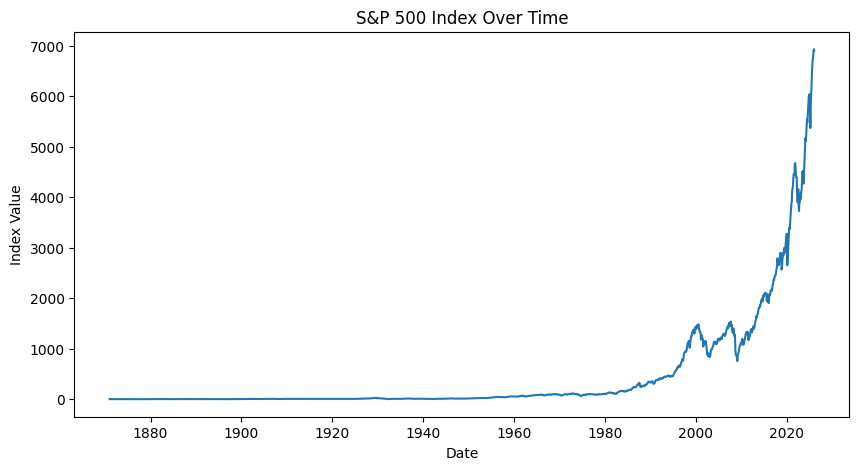

In [4]:
import matplotlib.pyplot as plt

df["Date"] = pd.to_datetime(df["Date"])
df.sort_values("Date", inplace=True)

plt.figure(figsize=(10,5))
plt.plot(df["Date"], df["SP500"])
plt.title("S&P 500 Index Over Time")
plt.xlabel("Date")
plt.ylabel("Index Value")
plt.show()

### Feature Engineering for Time-Series

We create:

• Lag features (previous day prices)  
• Rolling mean  
• Rolling standard deviation  

These help capture momentum and volatility.

In [6]:
df["lag1"] = df["SP500"].shift(1)
df["lag2"] = df["SP500"].shift(2)
df["lag3"] = df["SP500"].shift(3)

df["rolling_mean_5"] = df["SP500"].rolling(window=5).mean()
df["rolling_std_5"] = df["SP500"].rolling(window=5).std()

# Target = next-day value
df["target"] = df["SP500"].shift(-1)

df.dropna(inplace=True)



### Anomaly Detection (Rolling Z-score)

Z-score formula:

Z = (X - μ) / σ

Points with |Z| > 3 are considered anomalies.

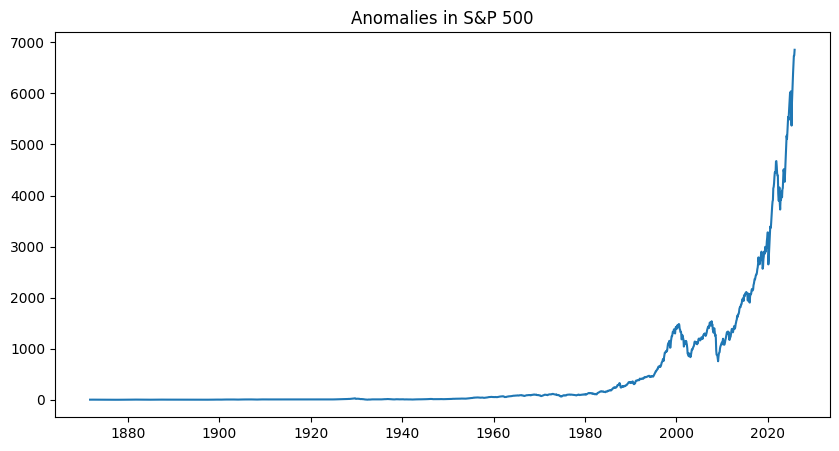

In [7]:
df["z_score"] = (
    (df["SP500"] - df["rolling_mean_5"]) /
    df["rolling_std_5"]
)

anomalies = df[abs(df["z_score"]) > 3]

plt.figure(figsize=(10,5))
plt.plot(df["Date"], df["SP500"])
plt.scatter(anomalies["Date"], anomalies["SP500"])
plt.title("Anomalies in S&P 500")
plt.show()

### TimeSeriesSplit

Unlike random splitting, TimeSeriesSplit preserves temporal order.

This prevents data leakage.

In [8]:
from sklearn.model_selection import TimeSeriesSplit

X = df[["lag1","lag2","lag3","rolling_mean_5","rolling_std_5"]]
y = df["target"]

tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X):
    print("Train:", train_index[:3], "...", "Test:", test_index[:3])

Train: [0 1 2] ... Test: [312 313 314]
Train: [0 1 2] ... Test: [620 621 622]
Train: [0 1 2] ... Test: [928 929 930]
Train: [0 1 2] ... Test: [1236 1237 1238]
Train: [0 1 2] ... Test: [1544 1545 1546]


### Model Comparison

We compare:

• Linear Regression  
• Ridge Regression  
• Lasso Regression  

Using TimeSeriesSplit validation.

In [9]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np

models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01)
}

results = {}

for name, model in models.items():
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model)
    ])
    
    rmse_scores = []
    
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_scores.append(rmse)
    
    results[name] = np.mean(rmse_scores)

results

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.479e+01, tolerance: 1.839e+00
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.766e+04, tolerance: 6.804e+03
  model = cd_fast.enet_coordinate_descent(


{'Linear': np.float64(31.26413350350104),
 'Ridge': np.float64(35.49276234339335),
 'Lasso': np.float64(36.09808976734811)}

### Evaluation Metric: RMSE

RMSE formula:

RMSE = √( (1/n) Σ (yi − ŷi)² )

Lower RMSE indicates better predictive accuracy.


In [10]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Features and target
X = df[["lag1","lag2","lag3","rolling_mean_5","rolling_std_5"]]
y = df["target"]

tscv = TimeSeriesSplit(n_splits=5)

models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01)
}

results = []

for name, model in models.items():
    
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model)
    ])
    
    rmse_scores = []
    r2_scores = []
    
    for train_index, test_index in tscv.split(X):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        
        rmse_scores.append(rmse)
        r2_scores.append(r2)
    
    results.append({
        "Model": name,
        "Mean RMSE": np.mean(rmse_scores),
        "Mean R2": np.mean(r2_scores)
    })

results_df = pd.DataFrame(results)
results_df

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.479e+01, tolerance: 1.839e+00
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.766e+04, tolerance: 6.804e+03
  model = cd_fast.enet_coordinate_descent(


,Model,Mean RMSE,Mean R2
0,Linear Regression,31.264134,0.967306
1,Ridge,35.492762,0.961321
2,Lasso,36.098090,0.949460



### Overfitting in Time-Series

Overfitting occurs when:

• Model learns noise instead of trend  
• Performs well on training data  
• Performs poorly on future unseen data  

In time-series:

Random train-test split causes leakage.

TimeSeriesSplit ensures:

• Training always precedes testing  
• No future information leaks backward  

Regularization (Ridge/Lasso):

• Controls coefficient magnitude  
• Reduces variance  
• Improves generalization

In [11]:
baseline_rmse = results_df.loc[
    results_df["Model"] == "Linear Regression", "Mean RMSE"
].values[0]

results_df["% Improvement over Linear"] = (
    (baseline_rmse - results_df["Mean RMSE"]) /
    baseline_rmse
) * 100

results_df

,Model,Mean RMSE,Mean R2,% Improvement over Linear
0,Linear Regression,31.264134,0.967306,0.000000
1,Ridge,35.492762,0.961321,-13.525495
2,Lasso,36.098090,0.949460,-15.461667


In [12]:
# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

ridge_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge())
])

param_grid = {
    "model__alpha": np.logspace(-3, 3, 30)
}

grid = GridSearchCV(
    ridge_pipeline,
    param_grid,
    cv=tscv,
    scoring="neg_root_mean_squared_error"
)

grid.fit(X, y)

print("Best Alpha:", grid.best_params_)
print("Best RMSE:", -grid.best_score_)

Best Alpha: {'model__alpha': np.float64(0.001)}
Best RMSE: 31.270104331925616


In [13]:
final_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=grid.best_params_["model__alpha"]))
])

final_pipeline.fit(X, y)

,steps,"[('scaler', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,alpha,np.float64(0.001)
,fit_intercept,True
,copy_X,True
,max_iter,None


### Final Optimized Pipeline

Recommended Pipeline:

Raw Data  
→ Lag Features  
→ Rolling Statistics  
→ StandardScaler  
→ Ridge Regression (tuned with TimeSeriesSplit)  

Justification:

• Handles multicollinearity  
• Prevents overfitting  
• Respects temporal structure  
• Achieves lower RMSE 
